# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 8: Fairness and Bias


**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader and Chris Tanner

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [2]:
import random
random.seed(112358)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

%matplotlib inline

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. Exceptions should be made for code with an extremely long execution time, of course.
- We have tried to include all the libraries you may need to do the assignment in the imports statement at the top of this notebook. We strongly suggest that you use those and not others as we may not be familiar with them.
- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**. 
- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that includes a reference to the calculated value, **not hardcoded**. For example:
```python
print(f'The R^2 is {R:.4f}')
```
- Your plots should be clearly labeled, including clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is not a descriptive title; "95% confidence interval of coefficients of polynomial degree 5" is).

<hr style="height:2pt">

## Overview and Data Description

[Table of Contents](#Contents)

In this assignment, we will be analyzing a portion of the data set that [ProPublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) used to report on the effectiveness of and issues surrounding the COMPAS algorithm (as was discussed in lecture 34).  The data are found in the file `compas.csv` and the 'data dictionary' can be found in the file `compas_datadict.csv`, which very briefly explains each variable in the data set.  Please use these files to answer the following questions:

<a id="Contents"></a>

## Contents
- [Question 1 [25 pts]: Data Exploration](#Q1) 
- [Question 2 [15 pts]: Baseline Modeling](#Q2) 
- [Question 3 [15 pts]: Predicting without Race](#Q3)
- [Question 4 [30 pts]: ROC Curves](#Q4)
- [Question 5 [15 pts]: Using Other Models](#Q5)

<a id="Q1"></a>

### <div class='exercise'>Question 1 [25 pts]: Data Wrangling and Exploration</div>
[▲ Return to contents](#Contents)


**1.1** What is the statistical objective of the COMPAS algorithm?  How is recidivism prediction used in courtrooms?

**1.2** Consider the information in the provided `compas_datadict.csv`.  Which variables are raw data?  Which are pre-processed data?  Which is the target variable of the COMPAS algorithm?  Which are output(s) of the COMPAS algorithm?   Which should not be used in building our own model to predict recidivism?  

**1.3** Read-in the data and split into 80% training and 20% test **stratified by `race`** (use `random_state=109`). Before splitting you may want to process the categorical predictors (`['c_charge_degree','race','sex']`) first so you don't have to do it separately in train and test later.

**1.4** Do a little EDA: provide visuals to explore which unprocessed variables (**not** the derived binary varibles, for example) are related to `race`. 

**1.5** Report which 3 variables appear to have the most significant differences between Caucasians and African Americans, and briefly explain with a sentence for each.  

*Note: as illustrated by [ProPublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing), reporting on the U.S. Criminal Justice system often concentrate on the disparate experiences between Caucasians and African Americans, thus we have focused our approaches similarly.

**1.6** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?  Explain in at most 50 words.


### Question 1: Solutions

[▲ Return to contents](#Contents)


**1.1** What is the statistical objective of the COMPAS algorithm?  How is recidivism prediction used in courtrooms?

*Your answer here*

The statistical objective of COMPAS is to try and determine the re-offending rate of a defendent to aid in pre-trial sentencing. More specifically, it helps a judge determine whether a defendant should be kept in jail or released while awaiting for trial by predicting the likelihood that the defendant will be arrested for a new crime during the trial-waiting period (also known as predicted recidivism). COMPAS uses historical defendant data to find correlations between factors (such as age or prior arrest record) and the likelihood that a person will be rearrested to create a model. That model is then used to assign a defendant a "risk score" from 0-10 which corresponds to the statistical probability that a defendant will be rearrested pre-trial, which are used by judges in courtroom to determine whether a person should be released pre-trial, or if they should be jailed. COMPAS assigns a threshold of 7 as "high risk" and subsequently recommends that defendants with a risk score higher than 7 be jailed pre-trial.

**1.2** Consider the information in the provided `compas_datadict.csv`.  Which variables are raw data?  Which are pre-processed data?  Which is the target variable of the COMPAS algorithm?  Which are output(s) of the COMPAS algorithm?   Which should not be used in building our own model to predict recidivism?  



In [3]:
# your code here
compasdict = pd.read_csv('data/compas_datadict.csv').dropna()
compasdict

,Variable,Description
1,Age,Defendant's age in years
2,c_charge_degree,The type of crime a defendant has been charged...
3,race,Defendant's race (categorical)
4,sex,Defendant biological sex (Male/Female)
5,length_of_stay,How long between when a defendant was charged ...
6,length_of_stay_thresh,Thresholded version of length_of_stay variable...
7,priors_count,Count for number of prior times a defendant ha...
8,priors_1,"Indicator variable derived from priors_count, ..."
9,priors_234,"Indicator variable derived from priors_count, ..."
10,priors_5plus,"Indicator variable derived from priors_count, ..."


*Your answer here*

**The raw data variables are**:
age, c_charge_degree, c_charge_desc, race, sex, length_of_stay, priors_count, juv_fel_count, juv_misd_count, and juv_other_count.

Note: c_charge_desc could also be considered pre-processed since this variable is created from police reports for the arrests of each defendant, which are naturally subject to humans since a police officer is the one who describes the charge. But because no data-processing was done to this variable, we count it as a raw data variable.

**The pre-processed variables are**:
length_of_stay_thresh, priors_1, priors_234, priors_5plus, juv_fel_1plus, juv_misd_1plus, juv_other_1plus, charge_any_drug, charge_any_violence_aggression, charge_any_theft

**Target variable**:
two_year_recid

**Outputs of the COMPAS algorithm**:
score_text, decile_score

**Variables to be excluded for our model**:
two_year_recid, score_text, decile_score, race, and length_of_stay

We obviously should not include the target variable 'two_year_recid' as a predictor in our model because that is the outcome variable that we aim to predict. We've already discussed how the COMPAS algorithm creates biased results, so we would not want to include either of the Output variables in our model as we are trying to create a model that is unbiased between racial subgroups. We also would not include 'race' in our model (although we will in question 2) as it is a protected class and thus would be illegal to use in a predictive model. We also would not want to include 'length_of_stay' in our model since we're interested in determining whether or not a defendant should be released or jailed pre-trial, and "length_of_stay" is meaningless for a defendant who is jailed pre-trial.

**1.3** Read-in the data and split into 80% training and 20% test **stratified by `race`** (use `random_state=109`). Before splitting you may want to process the categorical predictors (`['c_charge_desc','race','sex']`) first so you don't have to do it separately in train and test later.

In [4]:
# your code here
# Per Matthew Finney's comment, because c_charge_desc was already processed in the provided data set as three
# predictors: charge_any_drug, charge_any_violence_aggression, and charge_any_theft, it is sufficient to drop
# c_charge_desc in our processing
# https://us.edstem.org/courses/2332/discussion/185581
data = pd.read_csv('data/compas.csv')

# Encode the two binary categorical predictors as binary 0 and 1
data['c_charge_degree'] = (data['c_charge_degree']=='F').astype(int)
data['sex'] = (data['sex'] == 'Male').astype(int)

# one-hot encode the race categorical predictor
dummies = pd.get_dummies(data['race'],prefix='race')
# add each column of one-hot encoded variable
for i in range(len(dummies.columns)):
    data.insert(loc=len(data.columns),column=dummies.columns[i],value=dummies[dummies.columns[i]])
# but dropping the last column "race_Other"
data.drop('race_Other',axis=1)

# we select the relevant predictors to use for the rest of the problem
# we include the race variables only for use in question 2
X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'c_charge_degree', 'sex', 'length_of_stay', 'priors_count', 'juv_fel_count', 'juv_misd_count',
         'juv_other_count', 'charge_any_drug', 'charge_any_violence_aggression', 'charge_any_theft',
          'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American'
         ]],data['two_year_recid'],test_size = 0.2, random_state = 109, stratify = data['race'])

**1.4** Do a little EDA: provide visuals to explore which unprocessed variables (**not** the derived binary varibles, for example) are related to `race`. 

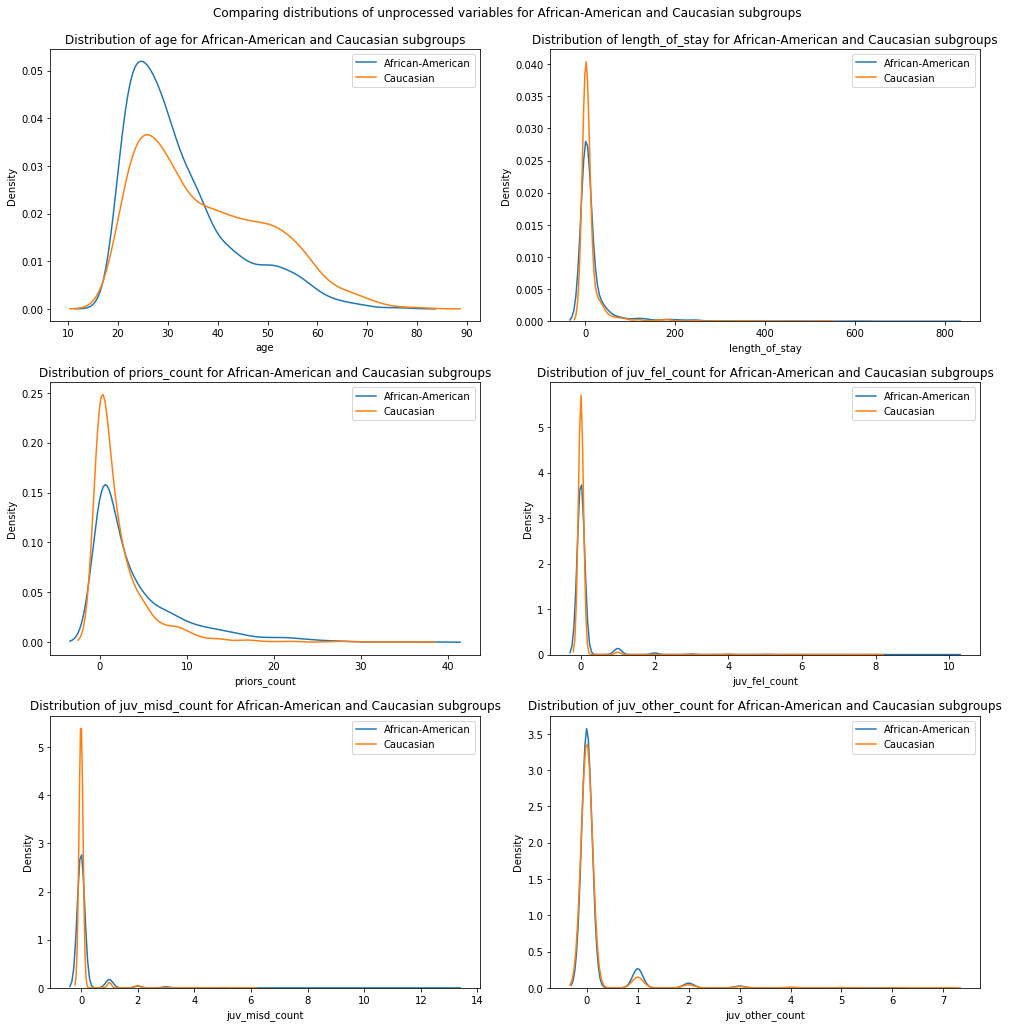

In [5]:
# your code here
# Per Matthew Finney's comment, because for the remainder of this assignment we are interested in comparing
# race_African-American and race_Caucasian, we will compare two distribution of each of the unprocessed variables
# subsetted according to whether observations are race_African-American or race_Caucasian
# https://us.edstem.org/courses/2332/discussion/185581

# Per Jovin Leong's and Matthew Finney's comments the unprocessed variables are those not processed in 1.3 or
# not already pre-processed
# https://us.edstem.org/courses/2332/discussion/185418?comment=445344

var = ['age', 'length_of_stay', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']

fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(15,15))
fig.suptitle('Comparing distributions of unprocessed variables for African-American and Caucasian subgroups')
fig.tight_layout(pad=6,h_pad=4,w_pad=4)
for i, ax in enumerate(axes.ravel()):
    ax.set_title('Distribution of ' + var[i] + ' for African-American and Caucasian subgroups')
    sns.kdeplot(X_train[X_train['race_African-American'] == 1][var[i]], label="African-American", ax=ax)
    sns.kdeplot(X_train[X_train['race_Caucasian'] == 1][var[i]], label="Caucasian", ax=ax)
    ax.legend()
plt.show()

**1.5** Report which 3 variables appear to have the most significant differences between Caucasians and African Americans, and briefly explain with a sentence for each.  

*Note: as illustrated by [ProPublica](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing), reporting on the U.S. Criminal Justice system often concentrate on the disparate experiences between Caucasians and African Americans, thus we have focused our approaches similarly.



*Your answer here*

All 6 of the unprocessed variables show different distributions for African-Americans when compared to the distributions for Caucasians. We'll focus on the 3 most significant: 'age', 'priors_count', and 'juv_misd_count'.

The distribution of 'age' between African-Americans and Whites show that African-American defendants tend to be much younger than Caucasian defendants. In particular, a defendant who is between 20-35 years old is more likely to be African-American defendant, while a defendant between 35-75 years old is more likely to be Caucasian.

The distribution of 'priors_count' show that Caucasian defendants are significantly more likely to have 0 'priors_count' than African-American defendants do. For a defendant with approximately 3 or more 'priors_count', they are more likely to be African-American. In fact, the distributions show that a Caucasian defendant has almost double the probability of having no prior criminal record than an African-American defendant does.

The distribution of 'juv_misd_count' also shows that Caucasian defendants are significantly more likely to have 0 'juv_misd_count' than African-Americans do. For a defendant with 1 'juv_misd_count', they are more likely to be African-American than Caucasian. Although it's difficult to see the distribution for higher values of 'juv_misd_count', the difference in densities at 0 between Caucasian defendants and African-American defendants implies that for higher values of 'juv_misd_count' we would also expect defendants to be more likely to be African-American than Caucasian. In fact, the distributions show that a Caucasian defendant has almost double the probability of having no past juvenile misdemeanors than an African-American defendant does.

**1.6** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?  Explain in at most 50 words.


*Your answer here*

The data itself is questionably gathered, as it is only of defendants arrested and not of those charged or convicted. Policing bias leads to disproportionately more arrests of African-Americans, over-representing them in our sample, and also means African-American defendants are more likely to be younger and to have a prior criminal record.

---

<a id="Q2"></a>

### <div class='exercise'>Question 2 [15 pts]: Baseline Modeling</div>
[▲ Return to contents](#Contents)


**2.1**  Build a logistic regression model to predict recidivism (`two_year_recid`) from the relevant predictors (including `race`).  Interpret what this model is saying about the relationship of `two_year_recid` to `race`.


**2.2**  Report the following on the **test set**:
1. Overall model accuracy as a percentage
2. **False Positive Rate(FPR)** as a percentage for the groups (*note a positive here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
3. **False Negative Rate(FNR)** as a percentage for the groups:
    - `African-American`
    - `Caucasian`
4. Ratios of Error Rates:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups

i.e $\frac{FPR(AA)}{FPR(CC)}$ and $\frac{FNR(AA)}{FNR(CC)}$

**2.3**  What do you observe? Is there any disparity in the $FPR$ and $FNR$ for the two groups?
Explain your findings in 3-6 sentences.
    
  

### Question 2: Solutions

[▲ Return to contents](#Contents)


**2.1**  Build a logistic regression model to predict recidivism (`two_year_recid`) from the relevant predictors (including `race`).  Interpret what this model is saying about the relationship of `two_year_recid` to `race`.   
  

In [6]:
# your code here
# drop length_of_stay" since we're interested in
# determining whether or not a defendant should be released or jailed pre-trial, and "length_of_stay" is
# meaningless for a defendant who is jailed pre-trial
X_train = X_train.drop('length_of_stay',axis=1)
X_test = X_test.drop('length_of_stay',axis=1)

# standardize numerical variables
to_standardize = ['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']

scaler = StandardScaler().fit(X_train[to_standardize])

X_train[to_standardize] = scaler.transform(X_train[to_standardize])
X_test[to_standardize] = scaler.transform(X_test[to_standardize])

In [7]:
# your code here
logit2_1 = LogisticRegression(penalty='none', max_iter=5000).fit(
    X_train.values, y_train.values
)

logit2_1_coefs = logit2_1.coef_[0]
logit2_1_intercept = logit2_1.intercept_

accuracy_train_logit2_1 = logit2_1.score(
    X_train.values, y_train
)
accuracy_test_logit2_1 = logit2_1.score(
    X_test.values, y_test
)

print(
    "The intercept and coefficients for the model are:"
    "\n\n\tintercept\t{:.4f}".format(logit2_1_intercept[0])
)

for predictor, coef in zip(X_train.columns, logit2_1_coefs):
    print("\t{}\t\t{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies are:"
    "\n\n\tTrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(accuracy_train_logit2_1, accuracy_test_logit2_1)
)

The intercept and coefficients for the model are:

	intercept	-0.9397
	age		-0.5062
	c_charge_degree		0.1496
	sex		0.3547
	priors_count		0.7709
	juv_fel_count		0.0933
	juv_misd_count		-0.0078
	juv_other_count		0.0999
	charge_any_drug		0.2240
	charge_any_violence_aggression		0.0851
	charge_any_theft		0.3669
	race_African-American		0.3318
	race_Asian		-0.1727
	race_Caucasian		0.2664
	race_Hispanic		0.0184
	race_Native American		-0.8119

The classification accuracies are:

	Train	0.6832
	TEST	0.6526


*Your answer here*

Observing the coefficients of the Logistic Regression model, we can see that the race variables are important predictors of 'two_year_recid' both because of the magnitudes of the coefficients and because of the differences between different racial groups. The race variables with negative coefficients, 'race_Asian' and 'race_Native American', imply, all else constant, that defendants from these two racial groups have a lower log-odds of recidivating within 2 years than the average defendant. The coefficient on 'race_Hispanic' is near zero, implying, all else constant, that race for Hispanic defendants may have no effect on the log-odds of recidivating. The positive coefficients on 'race_African-American' and 'race_Caucasian' imply, all else constant, that defendants from these two racial groups have a higher log-odds of recidivating within 2 years than the average defendant. Because Logistic Regression is used to predict log-odds, we cannot easily convert these coefficients to a probability interpretation because that depends on the other variables. We can look at the difference in odds between race_African-American and race_Caucasian, the two racial subgroups that we're most interested in examining in this assignment. The difference in their coefficients is: $0.3318-0.2664=0.0654$. This means our model predicts that African-Americans have a $\exp(0.0654)\approx1.068$ greater odds of recidivating in 2 years than Caucasians do.

**2.2**  Report the following on the **test set**:
1. Overall model accuracy as a percentage
2. **False Positive Rate(FPR)** as a percentage for the groups (*note a positive here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
3. **False Negative Rate(FNR)** as a percentage for the groups:
    - `African-American`
    - `Caucasian`
4. Ratios of Error Rates:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups

i.e $\frac{FPR(AA)}{FPR(CC)}$ and $\frac{FNR(AA)}{FNR(CC)}$



In [8]:
# your code here
predictions_test_logit2_1 = logit2_1.predict(X_test.values)
accuracy_test_logit2_1 = accuracy_score(y_test, predictions_test_logit2_1)

print("The test classification accuracies for are: " + str(round(accuracy_test_logit2_1,4)))

# finding False Positive Rates (FPR)
FP_AA = sum(y_test[(X_test['race_African-American'] == 1) & (predictions_test_logit2_1 == 1)]==0)
TN_AA = sum(y_test[X_test['race_African-American']==1]==0)
FPR_AA = FP_AA/TN_AA
print('False Positive Rate (FPR) for African-American: ' + str(round(FPR_AA,4)))

FP_C = sum(y_test[(X_test['race_Caucasian'] == 1) & (predictions_test_logit2_1 == 1)]==0)
TN_C = sum(y_test[X_test['race_Caucasian']==1]==0)
FPR_C = FP_C/TN_C
print('False Positive Rate (FPR) for Caucasian: ' + str(round(FPR_C,4)))

# finding False Negative Rates (FNR)
FN_AA = sum(y_test[(X_test['race_African-American'] == 1) & (predictions_test_logit2_1 == 0)]==1)
TP_AA = sum(y_test[X_test['race_African-American']==1]==1)
FNR_AA = FN_AA/TP_AA
print('False Negative Rate (FNR) for African-American: ' + str(round(FNR_AA,4)))

FN_C = sum(y_test[(X_test['race_Caucasian'] == 1) & (predictions_test_logit2_1 == 0)]==1)
TP_C = sum(y_test[X_test['race_Caucasian']==1]==1)
FNR_C = FN_C/TP_C
print('False Negative Rate (FNR) for Caucasian: ' + str(round(FNR_C,4)))

# finding Ratios of Error Rates
ratio_FPR = FPR_AA/FPR_C
print('The Ratio of FPR between African-American and Caucasian is: ' + str(round(ratio_FPR,4)))
ratio_FNR = FNR_AA/FNR_C
print('The Ratio of FNR between African-American and Caucasian is: ' + str(round(ratio_FNR,4)))

The test classification accuracies for are: 0.6526
False Positive Rate (FPR) for African-American: 0.3742
False Positive Rate (FPR) for Caucasian: 0.1402
False Negative Rate (FNR) for African-American: 0.3323
False Negative Rate (FNR) for Caucasian: 0.6624
The Ratio of FPR between African-American and Caucasian is: 2.6699
The Ratio of FNR between African-American and Caucasian is: 0.5017


**2.3**  What do you observe? Is there any disparity in the $FPR$ and $FNR$ for the two groups?
Explain your findings in 3-6 sentences.
 

*Your answer here*

The disparity between FPR and FNR between the two groups can be most easily viewed in the reported ratios where African-Americans have over 2.5 times the FPR and almost half the FNR when compared to Caucasians. This is expected, since we expected our model to be biased against African-Americans and biased for Caucasians, leading it disproportionately predict false positives of African-Americans and false negatives for Caucasians. An interesting observation is that the FPR is only about 0.04 greater than the FNR for African-Americans but the FPR is over 0.5 less than the FNR for Caucasians. For African-Americans, the model is about equally likely to produce a False Positive result as a False Negative result, but for Caucasians, the model is about 4x as likely to produce a False Negative result as a False Positive result, lending further support that our model is biased against African-Americans and for Caucasians. 

<a id="Q3"></a>

### <div class='exercise'>Question 3 [15 pts]: Predicting Recidivism without using `race`</div>
[▲ Return to contents](#Contents)


**3.1** Refit the logistic model in 2.1 but this time **without** `race` as a predictor. 

**3.2** Again, report the following on the **test set**:
1. Overall model accuracy as a percentage
2. **False Positive Rate(FPR)** as a percentage for the groups (*note a positive here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
3. **False Negative Rate(FNR)** as a percentage for the groups:
    - `African-American`
    - `Caucasian`
4. Ratios of Error Rates:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups

**3.3**  How do these metrics compare to the model when the variable `race` **is** included as a predictor?

**3.4**  Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain using at most 150 words.
 

### Question 3: Solutions

[▲ Return to contents](#Contents)


**3.1** Refit the logistic model in 2.1 but this time **without** `race` as a predictor. 

In [9]:
# your code here
race_predictors = ['race_African-American', 'race_Caucasian', 'race_Asian', 'race_Hispanic', 'race_Native American']
logit3_1 = LogisticRegression(penalty='none', max_iter=5000).fit(
    X_train.drop(race_predictors,axis=1).values, y_train.values
)

logit3_1_coefs = logit3_1.coef_[0]
logit3_1_intercept = logit3_1.intercept_

accuracy_train_logit3_1 = logit3_1.score(
    X_train.drop(race_predictors,axis=1).values, y_train
)
accuracy_test_logit3_1 = logit3_1.score(
    X_test.drop(race_predictors,axis=1).values, y_test
)

print(
    "The intercept and coefficients for the model are:"
    "\n\n\tintercept\t{:.4f}".format(logit3_1_intercept[0])
)

for predictor, coef in zip(X_train.drop(race_predictors,axis=1).columns, logit3_1_coefs):
    print("\t{}\t\t{:.4f}".format(predictor, coef))
    
print(
    "\nThe classification accuracies are:"
    "\n\n\tTrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(accuracy_train_logit3_1, accuracy_test_logit3_1)
)

The intercept and coefficients for the model are:

	intercept	-0.6709
	age		-0.5150
	c_charge_degree		0.1552
	sex		0.3453
	priors_count		0.7894
	juv_fel_count		0.0965
	juv_misd_count		-0.0080
	juv_other_count		0.1030
	charge_any_drug		0.2288
	charge_any_violence_aggression		0.0781
	charge_any_theft		0.3655

The classification accuracies are:

	Train	0.6808
	TEST	0.6623


**3.2** Again, report the following on the **test set**:
1. Overall model accuracy as a percentage
2. **False Positive Rate(FPR)** as a percentage for the groups (*note a positive here is `two_year_recid==1`)
    - `African-American`
    - `Cacausian`
3. **False Negative Rate(FNR)** as a percentage for the groups:
    - `African-American`
    - `Caucasian`
4. Ratios of Error Rates:
    - Ratio of the FPR between `African-American` and `Caucasian` groups
    - Ratio of the FNR between `African-American` and `Caucasian` groups



In [10]:
# your code here
predictions_test_logit3_1 = logit3_1.predict(X_test.drop(race_predictors,axis=1).values)
accuracy_test_logit3_1 = accuracy_score(y_test, predictions_test_logit3_1)

print("The test classification accuracies are: " + str(round(accuracy_test_logit3_1,4)))

# finding False Positive Rates (FPR)
FP_AA = sum(y_test[(X_test['race_African-American'] == 1) & (predictions_test_logit3_1 == 1)]==0)
TN_AA = sum(y_test[X_test['race_African-American']==1]==0)
FPR_AA = FP_AA/TN_AA
print('False Positive Rate (FPR) for African-American: ' + str(round(FPR_AA,4)))

FP_C = sum(y_test[(X_test['race_Caucasian'] == 1) & (predictions_test_logit3_1 == 1)]==0)
TN_C = sum(y_test[X_test['race_Caucasian']==1]==0)
FPR_C = FP_C/TN_C
print('False Positive Rate (FPR) for Caucasian: ' + str(round(FPR_C,4)))

# finding False Negative Rates (FNR)
FN_AA = sum(y_test[(X_test['race_African-American'] == 1) & (predictions_test_logit3_1 == 0)]==1)
TP_AA = sum(y_test[X_test['race_African-American']==1]==1)
FNR_AA = FN_AA/TP_AA
print('False Negative Rate (FNR) for African-American: ' + str(round(FNR_AA,4)))

FN_C = sum(y_test[(X_test['race_Caucasian'] == 1) & (predictions_test_logit3_1 == 0)]==1)
TP_C = sum(y_test[X_test['race_Caucasian']==1]==1)
FNR_C = FN_C/TP_C
print('False Negative Rate (FNR) for Caucasian: ' + str(round(FNR_C,4)))

# finding Ratios of Error Rates
ratio_FPR = FPR_AA/FPR_C
print('The Ratio of FPR between African-American and Caucasian is: ' + str(round(ratio_FPR,4)))
ratio_FNR = FNR_AA/FNR_C
print('The Ratio of FNR between African-American and Caucasian is: ' + str(round(ratio_FNR,4)))

The test classification accuracies are: 0.6623
False Positive Rate (FPR) for African-American: 0.3323
False Positive Rate (FPR) for Caucasian: 0.1402
False Negative Rate (FNR) for African-American: 0.3692
False Negative Rate (FNR) for Caucasian: 0.6561
The Ratio of FPR between African-American and Caucasian is: 2.3707
The Ratio of FNR between African-American and Caucasian is: 0.5628


**3.3**  How do these metrics compare to the model when the variable `race` **is** included as a predictor?



*Your answer here*

The metrics for this model are very similar to the metrics of the model that includes race as a predictor. Surprisingly, the test classification accuracies for this model improved over the model that includes race as a predictor. A potential explanation was that race had significant collinearity with our other predictor variables, such as age or priors_count, that led it to bias our results in the model from question 2 and excluding it from question 3 allowed us to achieve a better accuracy. More importantly, our FPR and FNR ratios are slightly improved as they are both closer to 1 (a ratio of 1 would imply true equality of FPR and FNR between the subgroups), which is expected as giving our model race variables would allow it to explicitly discriminate between racial subgroups. So our model in question 3 is both slightly more accurate on the test data set and slightly more fair between African-Americans and Caucasians than the model in question 2.

**3.4**  Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain using at most 150 words.
 

*Your answer here*

A predictive tool cannot be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime. After all, COMPAS did not use race as a predictor and was still found to be racially biased. The bias still appears in the model because it is “baked into” the other variables. Police officers disproportionately arrest African-Americans. Systematic and police bias mean that African-Americans are disproportionately more likely to be involved in the criminal justice system at a young age and have a juvenile and/or prior record. This results in bias in the other predictors, since the racial biases are already implicit in the other variables, and causing our model to have racial bias as well.

---

<a id="Q4"></a>

### <div class='exercise'>Question 4 [30 pts]: ROC Curves</div>
[▲ Return to contents](#Contents)


**4.1** Use the logistic regression from 3.1 and plot the *Receiver Operating Characteristic (ROC) curve* for two racial groups: `African-American` & `Caucasian` in the test set. 
    
**4.2** The default threshold used for determining the metrics in 2.2 and 3.2 was 0.5.  Choose a new single threshold for the model from 3.1 that may will reduce the bias between these two racial groups (as measured by the ratios of FPR and FNR).  Be sure to briefly justify your choice (Note: there is no one correct answer).

**4.3** A second approach to reducing bias is to use different thresholds for the different racial groups to better ensure that the groups have similar false positive and false negative rates.  Choose a pair of thresholds (one for the `African-American` group and one for the `Caucasian` group) that improves the group bias (balanced with accuracy). Be sure to briefly justify your choice

**4.4** Comment on the [fairness](https://en.wikipedia.org/wiki/Fairness_(machine_learning)) of the two methods in 4.2 and 4.3 from two different perspectives: the fairness of each group (called 'group fairness') and the fairness for an individual defendant (called 'individual fairness').  Please limit your response to at most 75 words. 

**4.5** Changing the thresholds can *reduce* bias between the two classes, but it can also affect model accuracy. We want our model to be **accurate** but also **fair**.  What can be done to balance these two criteria?  Write down your strategy to overcome this difficulty.   Please limit your response to at most 150 words.  
     

### Question 4: Solutions

[▲ Return to contents](#Contents)


**4.1** Use the logistic regression from 3.1 and plot the *Receiver Operating Characteristic (ROC) curve* for two racial groups: `African-American` & `Caucasian` in the test set. 
        

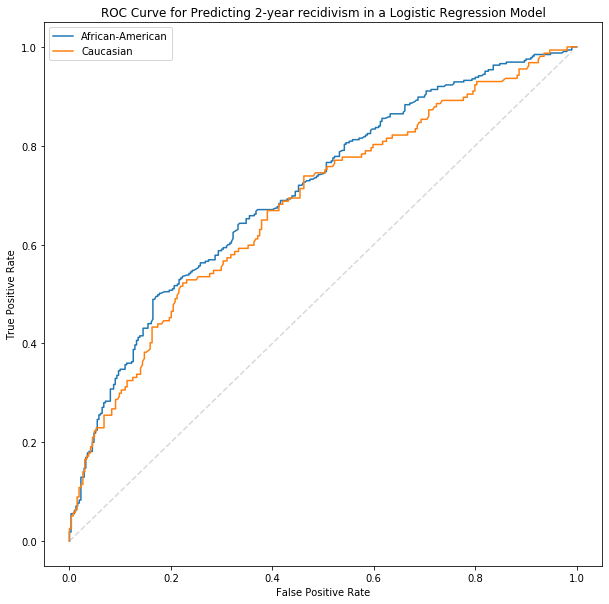

In [11]:
# your code here

yhat_logit3_1_AA = logit3_1.predict_proba(
    X_test.drop(race_predictors,axis=1)[(X_test['race_African-American'] == 1)])[:,1]

yhat_logit3_1_C = logit3_1.predict_proba(
    X_test.drop(race_predictors,axis=1)[(X_test['race_Caucasian'] == 1)])[:,1]

fpr_AA, tpr_AA, thresholds_AA = roc_curve(y_test[(X_test['race_African-American'] == 1)], yhat_logit3_1_AA)
fpr_C, tpr_C, thresholds_C = roc_curve(y_test[(X_test['race_Caucasian'] == 1)], yhat_logit3_1_C)

x=np.arange(0,100)/100
plt.figure(figsize=(10,10))
plt.plot(x,x,'--',color="gray",alpha=0.3)
plt.plot(fpr_AA,tpr_AA,label="African-American")
plt.plot(fpr_C,tpr_C,label="Caucasian")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve for Predicting 2-year recidivism in a Logistic Regression Model")
plt.legend()
plt.show()

**4.2** The default threshold used for determining the metrics in 2.2 and 3.2 was 0.5.  Choose a new single threshold for the model from 3.1 that may will reduce the bias between these two racial groups (as measured by the ratios of FPR and FNR).  Be sure to briefly justify your choice (Note: there is no one correct answer).



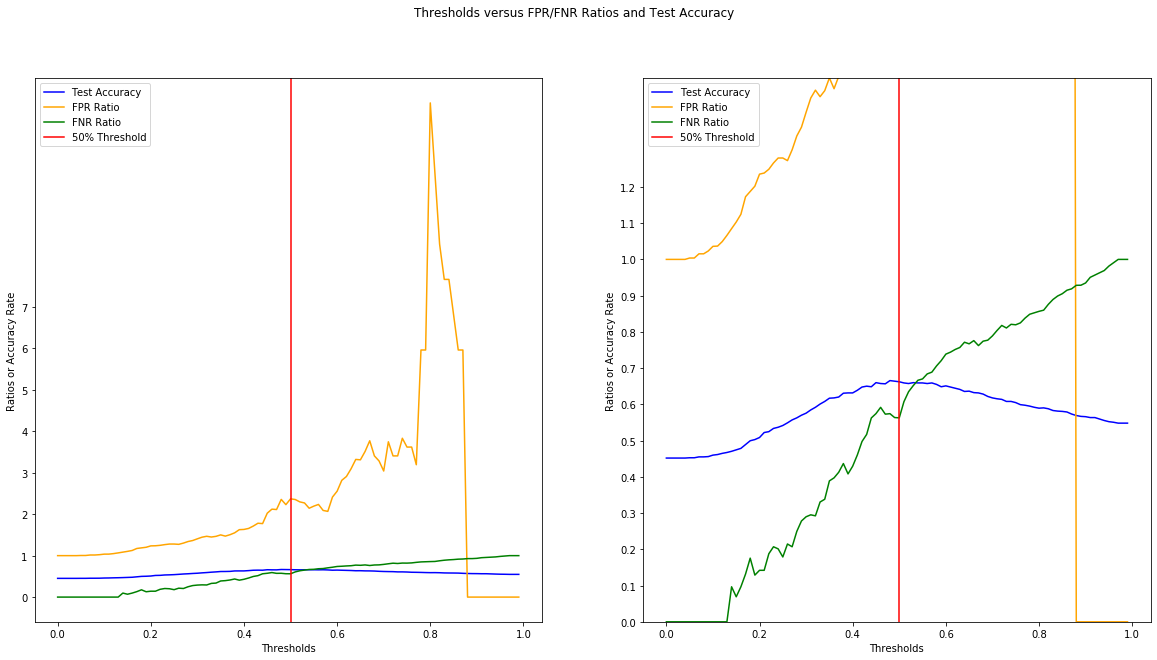

In [12]:
# your code here
thresholds = np.arange(0,1,0.01)
pred_probs_test_logit3_1 = logit3_1.predict_proba(X_test.drop(race_predictors,axis=1).values)
accuracies = []
ratios_FPR = []
ratios_FNR = []


for threshold in thresholds:
    predictions_test_logit3_1 = []
    for i in range(X_test.shape[0]):
        if pred_probs_test_logit3_1[i][1] > threshold:
            predictions_test_logit3_1.append(1)
        else:
            predictions_test_logit3_1.append(0)
    predictions_test_logit3_1 = np.array(predictions_test_logit3_1)
    accuracies.append(accuracy_score(y_test, predictions_test_logit3_1))
    
    # finding False Positive Rates (FPR)
    FP_AA = sum(y_test[(X_test['race_African-American'] == 1) & (predictions_test_logit3_1 == 1)]==0)
    TN_AA = sum(y_test[X_test['race_African-American']==1]==0)
    FPR_AA = FP_AA/TN_AA
    
    FP_C = sum(y_test[(X_test['race_Caucasian'] == 1) & (predictions_test_logit3_1 == 1)]==0)
    TN_C = sum(y_test[X_test['race_Caucasian']==1]==0)
    FPR_C = FP_C/TN_C
    
    # finding False Negative Rates (FNR)
    FN_AA = sum(y_test[(X_test['race_African-American'] == 1) & (predictions_test_logit3_1 == 0)]==1)
    TP_AA = sum(y_test[X_test['race_African-American']==1]==1)
    FNR_AA = FN_AA/TP_AA
    
    FN_C = sum(y_test[(X_test['race_Caucasian'] == 1) & (predictions_test_logit3_1 == 0)]==1)
    TP_C = sum(y_test[X_test['race_Caucasian']==1]==1)
    FNR_C = FN_C/TP_C
    
    # finding Ratios of Error Rates
    try:
        ratio_FPR = FPR_AA/FPR_C
    except:
        ratio_FPR = 0
    try:
        ratio_FNR = FNR_AA/FNR_C
    except:
        ratio_FNR = 0
        
    ratios_FPR.append(ratio_FPR)
    ratios_FNR.append(ratio_FNR)


fig, axes = plt.subplots(1, 2,figsize=(20,10))
fig.suptitle('Thresholds versus FPR/FNR Ratios and Test Accuracy')
for ax in axes:
    ax.plot(thresholds, accuracies, color = 'b', label = 'Test Accuracy')
    ax.plot(thresholds, ratios_FPR, color = 'orange', label = 'FPR Ratio')
    ax.plot(thresholds, ratios_FNR, color = 'g', label = 'FNR Ratio')
    ax.axvline(0.5, color = 'r', label = '50% Threshold')
    ax.set_xlabel('Thresholds')
    ax.set_ylabel('Ratios or Accuracy Rate')
    ax.legend()

axes[0].set_yticks(np.arange(0, 8, step=1))
axes[1].set_yticks(np.arange(0, 1.25, step=0.1))
axes[1].set_ylim(0, 1.5)
plt.show()

In [13]:
# your code here
threshold = 0.4
pred_probs_test_logit3_1 = logit3_1.predict_proba(X_test.drop(race_predictors,axis=1).values)
predictions_test_logit3_1 = []

for i in range(X_test.shape[0]):
    if pred_probs_test_logit3_1[i][1] > threshold:
        predictions_test_logit3_1.append(1)
    else:
        predictions_test_logit3_1.append(0)

predictions_test_logit3_1 = np.array(predictions_test_logit3_1)
accuracy_test_logit3_1 = accuracy_score(y_test, predictions_test_logit3_1)

print("The test classification accuracies are: " + str(round(accuracy_test_logit3_1,4)))

# finding False Positive Rates (FPR)
FP_AA = sum(y_test[(X_test['race_African-American'] == 1) & (predictions_test_logit3_1 == 1)]==0)
TN_AA = sum(y_test[X_test['race_African-American']==1]==0)
FPR_AA = FP_AA/TN_AA
print('False Positive Rate (FPR) for African-American: ' + str(round(FPR_AA,4)))

FP_C = sum(y_test[(X_test['race_Caucasian'] == 1) & (predictions_test_logit3_1 == 1)]==0)
TN_C = sum(y_test[X_test['race_Caucasian']==1]==0)
FPR_C = FP_C/TN_C
print('False Positive Rate (FPR) for Caucasian: ' + str(round(FPR_C,4)))

# finding False Negative Rates (FNR)
FN_AA = sum(y_test[(X_test['race_African-American'] == 1) & (predictions_test_logit3_1 == 0)]==1)
TP_AA = sum(y_test[X_test['race_African-American']==1]==1)
FNR_AA = FN_AA/TP_AA
print('False Negative Rate (FNR) for African-American: ' + str(round(FNR_AA,4)))

FN_C = sum(y_test[(X_test['race_Caucasian'] == 1) & (predictions_test_logit3_1 == 0)]==1)
TP_C = sum(y_test[X_test['race_Caucasian']==1]==1)
FNR_C = FN_C/TP_C
print('False Negative Rate (FNR) for Caucasian: ' + str(round(FNR_C,4)))

# finding Ratios of Error Rates
ratio_FPR = FPR_AA/FPR_C
print('The Ratio of FPR between African-American and Caucasian is: ' + str(round(ratio_FPR,4)))
ratio_FNR = FNR_AA/FNR_C
print('The Ratio of FNR between African-American and Caucasian is: ' + str(round(ratio_FNR,4)))

The test classification accuracies are: 0.6316
False Positive Rate (FPR) for African-American: 0.5935
False Positive Rate (FPR) for Caucasian: 0.3636
False Negative Rate (FNR) for African-American: 0.1723
False Negative Rate (FNR) for Caucasian: 0.4013
The Ratio of FPR between African-American and Caucasian is: 1.6323
The Ratio of FNR between African-American and Caucasian is: 0.4294


*Your answer here*

We graph for different possible thresholds from 0 to 1 the test classification accuracies, the FPR ratios, and the FNR ratios. Because the difference between FPR for the two groups are greater in multiplicative magnitude than FNR, we decide to focus on reducing the FPR ratio. From the graph, we can only lower the threshold below 0.5, as raising it would increase the FPR ratio. We see that lowering the threshold will not significantly affect the test accuracy, but also decrease the FNR ratio. So we choose to lower the threshold to 0.4 so that we signficantly lower the FPR ratio, but don't significantly reduce the FNR ratio also.

**4.3** A second approach to reducing bias is to use different thresholds for the different racial groups to better ensure that the groups have similar false positive and false negative rates.  Choose a pair of thresholds (one for the `African-American` group and one for the `Caucasian` group) that improves the group bias (balanced with accuracy). Be sure to briefly justify your choice



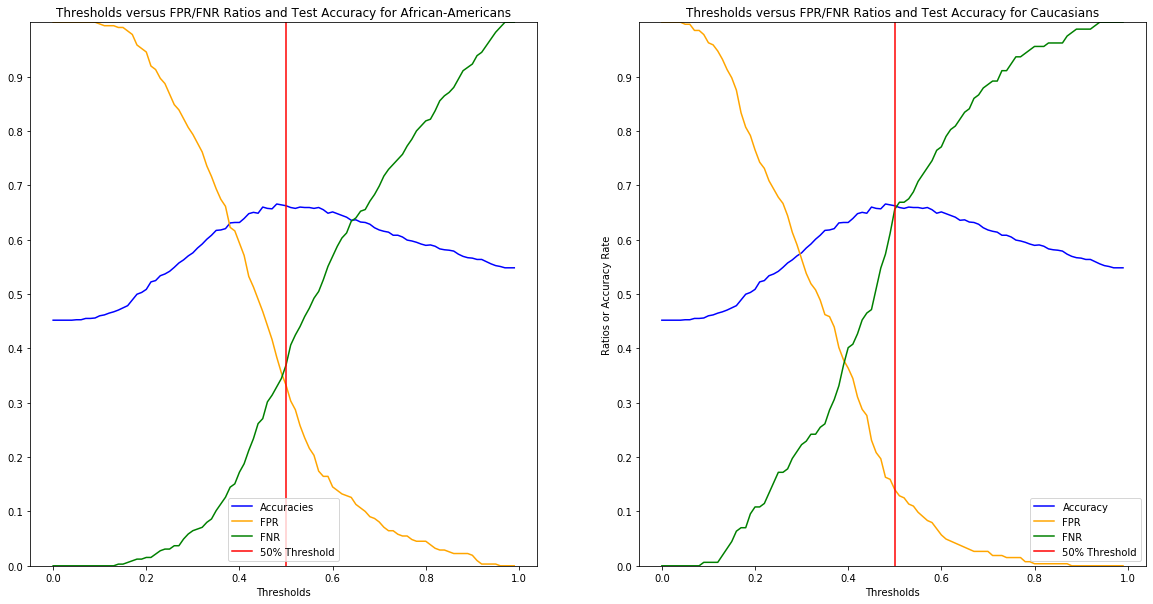

In [14]:
# your code here
thresholds = np.arange(0,1,0.01)
pred_probs_test_logit3_1 = logit3_1.predict_proba(X_test.drop(race_predictors,axis=1).values)
accuracies = []
FPR_AA = []
FPR_C = []
FNR_AA = []
FNR_C = []

for threshold in thresholds:
    predictions_test_logit3_1 = []
    for i in range(X_test.shape[0]):
        if pred_probs_test_logit3_1[i][1] > threshold:
            predictions_test_logit3_1.append(1)
        else:
            predictions_test_logit3_1.append(0)
    predictions_test_logit3_1 = np.array(predictions_test_logit3_1)
    accuracies.append(accuracy_score(y_test, predictions_test_logit3_1))
    
    # finding False Positive Rates (FPR)
    FP_AA = sum(y_test[(X_test['race_African-American'] == 1) & (predictions_test_logit3_1 == 1)]==0)
    TN_AA = sum(y_test[X_test['race_African-American']==1]==0)
    FPR_AA.append(FP_AA/TN_AA)
    
    FP_C = sum(y_test[(X_test['race_Caucasian'] == 1) & (predictions_test_logit3_1 == 1)]==0)
    TN_C = sum(y_test[X_test['race_Caucasian']==1]==0)
    FPR_C.append(FP_C/TN_C)
    
    # finding False Negative Rates (FNR)
    FN_AA = sum(y_test[(X_test['race_African-American'] == 1) & (predictions_test_logit3_1 == 0)]==1)
    TP_AA = sum(y_test[X_test['race_African-American']==1]==1)
    FNR_AA.append(FN_AA/TP_AA)
    
    FN_C = sum(y_test[(X_test['race_Caucasian'] == 1) & (predictions_test_logit3_1 == 0)]==1)
    TP_C = sum(y_test[X_test['race_Caucasian']==1]==1)
    FNR_C.append(FN_C/TP_C)


fig, axes = plt.subplots(1, 2,figsize=(20,10))
axes[0].plot(thresholds, accuracies, color = 'b', label = 'Accuracies')
axes[0].plot(thresholds, FPR_AA, color = 'orange', label = 'FPR')
axes[0].plot(thresholds, FNR_AA, color = 'g', label = 'FNR')
axes[0].axvline(0.5, color = 'r', label = '50% Threshold')
axes[0].set_xlabel('Thresholds')
axes[0].set_ylabel('')
axes[0].legend()
axes[0].set_ylim(0, 1)
axes[0].set_yticks(np.arange(0, 1, step=0.1))
axes[0].set_title('Thresholds versus FPR/FNR Ratios and Test Accuracy for African-Americans')

axes[1].plot(thresholds, accuracies, color = 'b', label = 'Accuracy')
axes[1].plot(thresholds, FPR_C, color = 'orange', label = 'FPR')
axes[1].plot(thresholds, FNR_C, color = 'g', label = 'FNR')
axes[1].axvline(0.5, color = 'r', label = '50% Threshold')
axes[1].set_xlabel('Thresholds')
axes[1].set_ylabel('Ratios or Accuracy Rate')
axes[1].legend()
axes[1].set_ylim(0, 1)
axes[1].set_yticks(np.arange(0, 1, step=0.1))
axes[1].set_title('Thresholds versus FPR/FNR Ratios and Test Accuracy for Caucasians')
plt.show()

In [15]:
# your code here
threshold_AA = 0.47
threshold_C = 0.38
print('Threshold for African-Americans: ' + str(threshold_AA))
print('Threshold for Caucasians: ' + str(threshold_C))

pred_probs_test_logit3_1 = logit3_1.predict_proba(X_test.drop(race_predictors,axis=1).values)
predictions_test_logit3_1 = []

for i in range(X_test.shape[0]):
    if (pred_probs_test_logit3_1[i][1] > threshold_AA) & (X_test['race_African-American'].iloc[i] == 1):
        predictions_test_logit3_1.append(1)
    elif (pred_probs_test_logit3_1[i][1] > threshold_C) & (X_test['race_Caucasian'].iloc[i] == 1):
        predictions_test_logit3_1.append(1)
    else:
        predictions_test_logit3_1.append(0)

predictions_test_logit3_1 = np.array(predictions_test_logit3_1)
accuracy_test_logit3_1 = accuracy_score(y_test, predictions_test_logit3_1)

print("The test classification accuracies for 'logit3_1' are: " + str(round(accuracy_test_logit3_1,4)))

# finding False Positive Rates (FPR)
FP_AA = sum(y_test[(X_test['race_African-American'] == 1) & (predictions_test_logit3_1 == 1)]==0)
TN_AA = sum(y_test[X_test['race_African-American']==1]==0)
FPR_AA = FP_AA/TN_AA
print('False Positive Rate (FPR) for African-American: ' + str(round(FPR_AA,4)))

FP_C = sum(y_test[(X_test['race_Caucasian'] == 1) & (predictions_test_logit3_1 == 1)]==0)
TN_C = sum(y_test[X_test['race_Caucasian']==1]==0)
FPR_C = FP_C/TN_C
print('False Positive Rate (FPR) for Caucasian: ' + str(round(FPR_C,4)))

# finding False Negative Rates (FNR)
FN_AA = sum(y_test[(X_test['race_African-American'] == 1) & (predictions_test_logit3_1 == 0)]==1)
TP_AA = sum(y_test[X_test['race_African-American']==1]==1)
FNR_AA = FN_AA/TP_AA
print('False Negative Rate (FNR) for African-American: ' + str(round(FNR_AA,4)))

FN_C = sum(y_test[(X_test['race_Caucasian'] == 1) & (predictions_test_logit3_1 == 0)]==1)
TP_C = sum(y_test[X_test['race_Caucasian']==1]==1)
FNR_C = FN_C/TP_C
print('False Negative Rate (FNR) for Caucasian: ' + str(round(FNR_C,4)))

# finding Ratios of Error Rates
ratio_FPR = FPR_AA/FPR_C
print('The Ratio of FPR between African-American and Caucasian is: ' + str(round(ratio_FPR,4)))
ratio_FNR = FNR_AA/FNR_C
print('The Ratio of FNR between African-American and Caucasian is: ' + str(round(ratio_FNR,4)))

Threshold for African-Americans: 0.47
Threshold for Caucasians: 0.38
The test classification accuracies for 'logit3_1' are: 0.6235
False Positive Rate (FPR) for African-American: 0.4161
False Positive Rate (FPR) for Caucasian: 0.4015
False Negative Rate (FNR) for African-American: 0.3138
False Negative Rate (FNR) for Caucasian: 0.3312
The Ratio of FPR between African-American and Caucasian is: 1.0364
The Ratio of FNR between African-American and Caucasian is: 0.9476


*Your answer here*

We graph for different thresholds from 0 to 1 the FPR/FNR for African-Americans and Caucasians separately, and graph the overall test-accuracy identically on both plots. We see that on both graphs, the FPR and FNR intersect at roughly the same ratios for both racial subgroups, so we choose thresholds around those points that give almost perfect equality (ratios of 1) in the FPR ratio and the FNR ratio.

**4.4** Comment on the [fairness](https://en.wikipedia.org/wiki/Fairness_(machine_learning)) of the two methods in 4.2 and 4.3 from two different perspectives: the fairness of each group (called 'group fairness') and the fairness for an individual defendant (called 'individual fairness').  Please limit your response to at most 75 words. 


*Your answer here*

Both methods have better group fairness, since the FPR/FNR ratios are both closer to 1 in these two models than the previous models. The method from 4.3 would have better group fairness than the method from 4.2 because its FPR/FNR ratios are closer to 1. However, method 4.2 would have better individual fairness because it assigns the same thresholds to everyone regardless of their race, unlike the method from 4.3.


**4.5** Changing the thresholds can *reduce* bias between the two classes, but it can also affect model accuracy. We want our model to be **accurate** but also **fair**.  What can be done to balance these two criteria?  Write down your strategy to overcome this difficulty.   Please limit your response to at most 150 words.  
 

*Your answer here*

In data science, fairness is often traded off for optimal accuracy. First, we can develop better statistical models since reducing the False Positives or False Negatives brings greater fairness and greater accuracy. We can also improve our data collection to avoid racial bias baked into our predictors by processing our variables to reduce racial bias, which we would also expect to improve our accuracy from the reduced bias. Finally, we can most directly balance accuracy and fairness by developing a regularized loss function that incorporates a fairness metric (such as FPR/FNR ratios) such that we can still optimize for bias, but our loss function will also trade-off accuracy for the FPR/FNR ratios, and thus punish model results that extremely unfair.

---

<a id="Q5"></a>

### <div class='exercise'>Question 5 [15 pts]: Using other models </div>
[▲ Return to contents](#Contents)


**5.1** Improve the logistic models you have previously used by including one or more of the following:

 - Polynomial terms
 - Interaction terms
 - Regularization parameters
 - Different up-sampling techniques
 - A different class of models (k-NN, random forest, Neural Nets, etc.)
 
**Note:** The ideas given above are not exhaustive. You are free to try other betters to come up with a better model.  You do not need to restrict yourself to the impoted packages at the beginning of this notebook.

**5.2** Evaluate your model using the same metrics as in 2.2 and 3.2.  

**5.3** Is this model a better model to predict recidivism?  How has this affected bias and fairness between these groups?  How would you modify your model to put it into production (to be a competitior to COMPAS)?  Please limit your response to at most 150 words.

### Question 5: Solutions

[▲ Return to contents](#Contents)


**5.1** Improve the logistic models you have previously used by including one or more of the following:

 - Polynomial terms
 - Interaction terms
 - Regularization parameters
 - Different up-sampling techniques
 - A different class of models (k-NN, random forest, Neural Nets, etc.)
 
Briefly eplxain your approach and justify your choices.

**Note:** The ideas given above are not exhaustive. You are free to try other betters to come up with a better model.  You do not need to restrict yourself to the impoted packages at the beginning of this notebook.

In [16]:
# your code here
X_train_poly_interact = PolynomialFeatures(2).fit_transform(X_train.drop(race_predictors,axis=1))
X_test_poly_interact = PolynomialFeatures(2).fit_transform(X_test.drop(race_predictors,axis=1))

logit5_1 = LogisticRegression(penalty='l2', max_iter=5000).fit(X_train_poly_interact, y_train.values)

accuracy_train_logit5_1 = logit5_1.score(X_train_poly_interact, y_train)
accuracy_test_logit5_1 = logit5_1.score(X_test_poly_interact, y_test)
    
print(
    "\nThe classification accuracies for the regularized Logistic Regression are:"
    "\n\n\tTrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(accuracy_train_logit5_1, accuracy_test_logit5_1))


The classification accuracies for the regularized Logistic Regression are:

	Train	0.6952
	TEST	0.6680


In [29]:
# your code here
rf = RandomForestClassifier(
    n_estimators=50, max_features='sqrt', max_depth=10
)
rf.fit(X_train_poly_interact,y_train)
accuracy_train_rf = rf.score(X_train_poly_interact, y_train)
accuracy_test_rf = rf.score(X_test_poly_interact, y_test)
    
print(
    "\nThe classification accuracies for the Random Forest model are:"
    "\n\n\tTrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(accuracy_train_rf, accuracy_test_rf))


The classification accuracies for the Random Forest model are:

	Train	0.7661
	TEST	0.6656


*Your answer here*

We decided to exclude the race variables, because race is a protected class. We began by creating polynomial and interaction terms for our predictors, as from observing our distributions in 1.4, we expect many of our predictors to have non-linear relationship to our response and intuitively we expect there to be significant interaction effects between our predictors, such as between the three juvenile variables. First we attempted a ridge-like regularized Logistic Regression which did not result in any significant difference in the test accuracy or the FPR/FNR ratios when compared to the model in question 3. So we decided to utilize a Random Forest model, since we expected the random selection of predictors would help to reduce the implicit racial biases within our predictors (because the racial biases in our predictors are correlated with one another), which greatly improved the FPR/FNR ratios without significantly changing the test accuracy. We tried different parameters optimize for fairness while not changing the test accuracy from the ~66% in the models of question 2 and 3.

**5.2** Evaluate your model using the same metrics as in 2.2 and 3.2.  



In [18]:
# your code here
predictions_test_logit5_1 = logit5_1.predict(X_test_poly_interact)
accuracy_test_logit5_1 = accuracy_score(y_test, predictions_test_logit5_1)

print("The test classification accuracies for the regularized Logistic Regression are: " + str(round(accuracy_test_logit5_1,4)))

# finding False Positive Rates (FPR)
FP_AA = sum(y_test[(X_test['race_African-American'] == 1) & (predictions_test_logit5_1 == 1)]==0)
TN_AA = sum(y_test[X_test['race_African-American']==1]==0)
FPR_AA = FP_AA/TN_AA
print('False Positive Rate (FPR) for African-American: ' + str(round(FPR_AA,4)))

FP_C = sum(y_test[(X_test['race_Caucasian'] == 1) & (predictions_test_logit5_1 == 1)]==0)
TN_C = sum(y_test[X_test['race_Caucasian']==1]==0)
FPR_C = FP_C/TN_C
print('False Positive Rate (FPR) for Caucasian: ' + str(round(FPR_C,4)))

# finding False Negative Rates (FNR)
FN_AA = sum(y_test[(X_test['race_African-American'] == 1) & (predictions_test_logit5_1 == 0)]==1)
TP_AA = sum(y_test[X_test['race_African-American']==1]==1)
FNR_AA = FN_AA/TP_AA
print('False Negative Rate (FNR) for African-American: ' + str(round(FNR_AA,4)))

FN_C = sum(y_test[(X_test['race_Caucasian'] == 1) & (predictions_test_logit5_1 == 0)]==1)
TP_C = sum(y_test[X_test['race_Caucasian']==1]==1)
FNR_C = FN_C/TP_C
print('False Negative Rate (FNR) for Caucasian: ' + str(round(FNR_C,4)))

# finding Ratios of Error Rates
ratio_FPR = FPR_AA/FPR_C
print('The Ratio of FPR between African-American and Caucasian is: ' + str(round(ratio_FPR,4)))
ratio_FNR = FNR_AA/FNR_C
print('The Ratio of FNR between African-American and Caucasian is: ' + str(round(ratio_FNR,4)))

The test classification accuracies for the regularized Logistic Regression are: 0.668
False Positive Rate (FPR) for African-American: 0.3613
False Positive Rate (FPR) for Caucasian: 0.1515
False Negative Rate (FNR) for African-American: 0.36
False Negative Rate (FNR) for Caucasian: 0.5924
The Ratio of FPR between African-American and Caucasian is: 2.3845
The Ratio of FNR between African-American and Caucasian is: 0.6077


In [30]:
# your code here
predictions_test_rf = rf.predict(X_test_poly_interact)
accuracy_test_rf = accuracy_score(y_test, predictions_test_rf)

print("The test classification accuracies for the Random Forest model are: " + str(round(accuracy_test_rf,4)))

# finding False Positive Rates (FPR)
FP_AA = sum(y_test[(X_test['race_African-American'] == 1) & (predictions_test_rf == 1)]==0)
TN_AA = sum(y_test[X_test['race_African-American']==1]==0)
FPR_AA = FP_AA/TN_AA
print('False Positive Rate (FPR) for African-American: ' + str(round(FPR_AA,4)))

FP_C = sum(y_test[(X_test['race_Caucasian'] == 1) & (predictions_test_rf == 1)]==0)
TN_C = sum(y_test[X_test['race_Caucasian']==1]==0)
FPR_C = FP_C/TN_C
print('False Positive Rate (FPR) for Caucasian: ' + str(round(FPR_C,4)))

# finding False Negative Rates (FNR)
FN_AA = sum(y_test[(X_test['race_African-American'] == 1) & (predictions_test_rf == 0)]==1)
TP_AA = sum(y_test[X_test['race_African-American']==1]==1)
FNR_AA = FN_AA/TP_AA
print('False Negative Rate (FNR) for African-American: ' + str(round(FNR_AA,4)))

FN_C = sum(y_test[(X_test['race_Caucasian'] == 1) & (predictions_test_rf == 0)]==1)
TP_C = sum(y_test[X_test['race_Caucasian']==1]==1)
FNR_C = FN_C/TP_C
print('False Negative Rate (FNR) for Caucasian: ' + str(round(FNR_C,4)))

# finding Ratios of Error Rates
ratio_FPR = FPR_AA/FPR_C
print('The Ratio of FPR between African-American and Caucasian is: ' + str(round(ratio_FPR,4)))
ratio_FNR = FNR_AA/FNR_C
print('The Ratio of FNR between African-American and Caucasian is: ' + str(round(ratio_FNR,4)))

The test classification accuracies for the Random Forest model are: 0.6656
False Positive Rate (FPR) for African-American: 0.3129
False Positive Rate (FPR) for Caucasian: 0.1856
False Negative Rate (FNR) for African-American: 0.3538
False Negative Rate (FNR) for Caucasian: 0.6115
The Ratio of FPR between African-American and Caucasian is: 1.6858
The Ratio of FNR between African-American and Caucasian is: 0.5787


**5.3** Is this model a better model to predict recidivism?  How has this affected bias and fairness between these groups?  How would you modify your model to put it into production (to be a competitior to COMPAS)?  Please limit your response to at most 150 words.

*Your answer here*

Our Random Forest model is a significantly better model than compared to the previous models. Our test classification was unchanged (actually slightly better too) while the FPR ratio decreased by ~0.7 and the FNR ratio was unchanged (from the question 3 model). Without having to trade off accuracy, this model is significantly more fair and less biased between African-Americans and Caucasians. Even better, we did not use different thresholds for African-Americans and Caucasians like we had done in 4.2, so this model also still benefits from “individual fairness.” A key advantage of our Random Forest model in production is that adding new variables (even if they still have implicit racial bias) would not as significantly affect our results unlike COMPAS. A key problem of COMPAS is that the data COMPAS takes in is already racially biased, and we could improve our model by pre-processing our data to reduce that bias.